# Map Training Analysis
*written by Viviane Kakerbeck*

#### Import Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.spatial import distance
import ezodf
from matplotlib.patches import Arrow, Circle
from PIL import Image

#### Define Paths
These two fields need to be set for each user individually. Set mapPath to your path leading to your map training data and taskPath to lead to your alignment task results.

In [2]:
#mapPath = "/Users/ingen/Dropbox/VR alignment/bachelor_master_Arbeiten/Laura/scripts/viewed_data/"
#taskPath = "/Users/ingen/Dropbox/VR alignment/bachelor_master_Arbeiten/Laura/scripts/over_all_subjects/trials_mat/"
#mapPath = "/Users/ingen/Dropbox/Project Seahaven/Tracking/MapResults/"
#taskPath = "/Users/ingen/Dropbox/Project Seahaven/Tracking/TaskPerformance/"
mapPath = "C:/Users/vivia/Dropbox/Project Seahaven/Tracking/MapResults/"
taskPath = "C:/Users/vivia/Dropbox/Project Seahaven/Tracking/TaskPerformance/"

#### File Dependencies:

For this script you need the following files:
* #.ods from Map training (location specified by mapPath)
* AlignmentVR_SubjNo_#.mat from Task (location specified by taskPath)

In the same folder as this script should be:

* complete_list_houses.txt (for house angles)
* HouseList.txt (for house coordinates)
* Seahaven alingment project.csv -> download from google spreadsheet with list of all recordings & discard marks

## Map Training

#### Load All Map Training Data Into a DataFrame - For .txt Files

In [4]:
def checkUsability(SNum,Rep=False):
    overview = pd.read_csv("./Seahaven alingment project.csv")
    if (overview.loc[overview['Subject#']==SNum].empty):
        #print(str(SNum)+" not in list.")
        if Rep == True:
            return False," "
        else:
            return False
    else:
        if (overview.loc[overview['Subject#']==SNum]['Discarded']=='yes').bool():
            #print(str(SNum)+" discarded.")
            if Rep == True:
                return False," "
            else:
                return False
        if Rep==False:
            if (overview.loc[overview['Subject#']==SNum]['Measurement#']>1).bool():
                #print(str(SNum)+" repeated measure.")
                return False
    if Rep==True:
        if (overview.loc[overview['Subject#']==SNum]['Repeated'].isnull()).bool():
            return False," "
        else:
            return True,(overview.loc[overview['Subject#']==SNum]['Repeated']).values[0]
    return True

#### Load All Map Training Data Into a DataFrame - For .osc Files

In [18]:
allFiles = os.listdir(mapPath)
g = open("./complete_list_houses.txt","r")
allHouses = []
for i in g:
    allHouses.append(str(int(i.split('_',1)[0])))
AllDf = pd.DataFrame(allHouses,columns=['House'])

for e in allFiles:
    start = 0
    lastI = 0
    lastV = 0
    if e.endswith(".ods") and checkUsability(int(e.split('.',1)[0])):
        doc = ezodf.opendoc(mapPath+e)
        sheet = doc.sheets[0]
        for i, row in enumerate(sheet.rows()):
            for cell in row:
                if cell.value=='Mouse Click Stats:':#only get mouse click stats, not hovering
                    start = i
                    Subjectdf = pd.DataFrame(columns=['House',str(int(e.split('.',1)[0]))])

                if start>0 and start<i-1 and cell.value!=None:

                    if lastI==i:
                        #print(str(int(lastV.split('_',1)[0])))#.split('\t',1)[1].split('\n',1)[0])
                        Subjectdf = Subjectdf.append({'House': str(int(lastV.split('_',1)[0])),str(e.split('.',1)[0]):int(cell.value)}, ignore_index=True)
                lastI = i
                lastV = cell.value
        AllDf = AllDf.merge(Subjectdf,on='House',sort=True,how='outer')
AllDf = AllDf.fillna(int(0))          
AllDf = AllDf.set_index('House')
AllDf = AllDf[~AllDf.index.duplicated(keep='first')]

In [19]:
len(AllDf.columns)# following analysis is of 60 subjects (there are 89 files in the folder but some are discarded 
#because of problems or because they are repeated measurements or not in the .csv file sheet)

64

### Take a Look at Map Training Data

#### Excerpt from Data Table

In [20]:
AllDf.head()

,1217,1385,1531,1533,1838,2007,2020,2256,2281,2325,...,8610,8756,8863,8990,9069,9246,9309,9826,9849,9998
House,,,,,,,,,,,,,,,,,,,,,
1,9,0,0,1,6,2,3,34,1,1,...,0,1,2,1,2,1,5,0,2,1
10,3,5,13,1,0,2,4,1,2,2,...,0,2,1,2,2,2,3,2,3,5
100,3,1,2,1,4,1,5,18,2,3,...,0,7,2,1,4,0,0,3,1,0
101,0,0,2,0,4,1,4,17,1,2,...,0,6,1,0,1,2,0,2,2,1
102,0,2,0,0,3,0,5,20,1,0,...,0,2,3,3,0,2,0,2,1,0


#### Save Table in Excel Format

In [21]:
AllDf.to_csv('ClickStatsAll.csv')

#### Load Table

In [51]:
AllDf = pd.read_csv('ClickStatsAll.csv').set_index('House')

#### Overall Statistics

In [52]:
AllDf.describe()

,1217,1385,1531,1533,1838,2007,2020,2256,2281,2325,...,8610,8756,8863,8990,9069,9246,9309,9826,9849,9998
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,...,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,3.352332,2.414508,15.932642,1.854922,3.958549,1.025907,3.191710,19.746114,2.051813,2.067358,...,1.274611,2.321244,1.803109,1.725389,1.880829,2.062176,2.362694,1.678756,2.316062,2.352332
std,2.081718,2.206571,10.463758,1.692412,2.672846,0.937835,2.282071,18.208080,1.345289,1.723194,...,1.146656,2.025981,1.105192,1.389030,1.168731,1.502175,2.383331,0.924445,1.577379,1.633059
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,5.000000,1.000000,2.000000,0.000000,2.000000,4.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,2.000000,18.000000,1.000000,4.000000,1.000000,3.000000,13.000000,2.000000,2.000000,...,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,5.000000,4.000000,24.000000,3.000000,6.000000,2.000000,4.000000,37.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000
max,10.000000,9.000000,43.000000,7.000000,10.000000,4.000000,13.000000,65.000000,6.000000,8.000000,...,6.000000,9.000000,6.000000,8.000000,6.000000,7.000000,20.000000,6.000000,8.000000,7.000000


#### Data Distributions

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


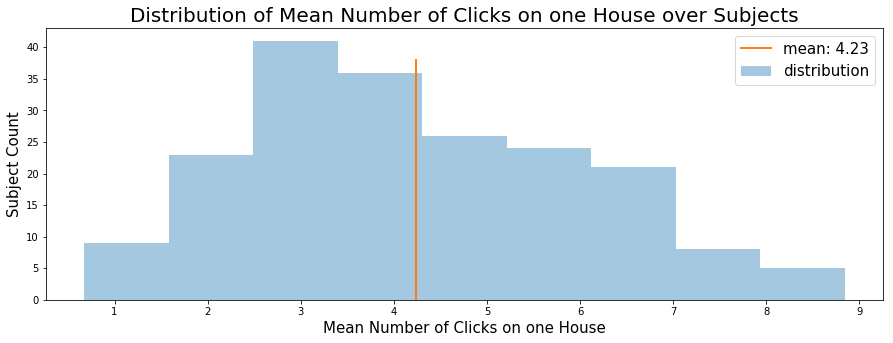

In [53]:
plt.figure(figsize=(15,5))
sns.distplot(AllDf.mean(axis=1),norm_hist=False,kde=False)# if you don't want pdf, set norm_hist=False,kde=False
plt.plot([np.mean(AllDf.mean(axis=1)), np.mean(AllDf.mean(axis=1))], [0, 38], linewidth=2)
plt.legend(['mean: '+str(np.mean(AllDf.mean(axis=1)))[:4],'distribution'],fontsize=15)
plt.title("Distribution of Mean Number of Clicks on one House over Subjects",fontsize=20)
plt.xlabel('Mean Number of Clicks on one House',fontsize=15)
plt.ylabel('Subject Count',fontsize=15)
#plt.show()
plt.savefig('Results\MeanClickDist.png')

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


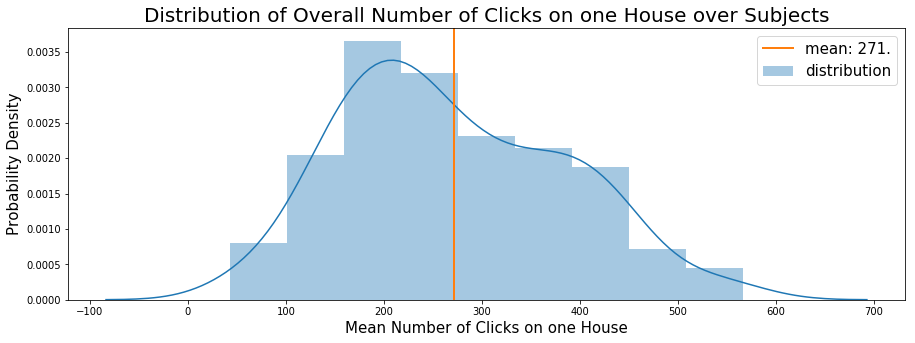

In [54]:
plt.figure(figsize=(15,5))
sns.distplot(AllDf.sum(axis=1))
plt.plot([np.mean(AllDf.sum(axis=1)), np.mean(AllDf.sum(axis=1))], [0, 1], linewidth=2)
plt.legend(['mean: '+str(np.mean(AllDf.sum(axis=1)))[:4],'distribution'],fontsize=15)
plt.title("Distribution of Overall Number of Clicks on one House over Subjects",fontsize=20)
plt.xlabel('Mean Number of Clicks on one House',fontsize=15)
plt.ylabel('Probability Density',fontsize=15)
#plt.show()
plt.savefig('Results\HouseClickDist.png')

This means an average amount of 262/60 = 4.366 on each house

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


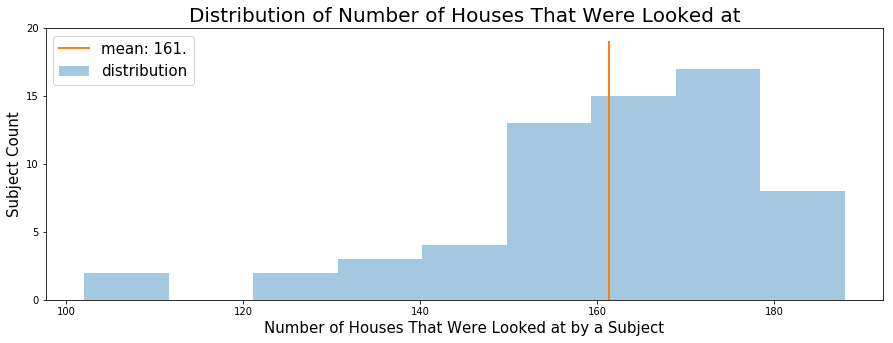

In [55]:
plt.figure(figsize=(15,5))
sns.distplot((AllDf > 0).astype(int).sum(axis=0),norm_hist=False,kde=False)
plt.plot([np.mean((AllDf > 0).astype(int).sum(axis=0)), np.mean((AllDf > 0).astype(int).sum(axis=0))], [0, 19], linewidth=2)
plt.yticks(np.arange(0, 21, step=5))
plt.legend(['mean: '+str(np.mean((AllDf > 0).astype(int).sum(axis=0)))[:4],'distribution'],fontsize=15)
plt.title("Distribution of Number of Houses That Were Looked at",fontsize=20)
plt.xlabel('Number of Houses That Were Looked at by a Subject',fontsize=15)
plt.ylabel('Subject Count',fontsize=15)
#plt.show()
plt.savefig('Results/ClickedDistAbsCount.png')

#### Plot Whole Click Distribution -> Any (Ir)regularities?

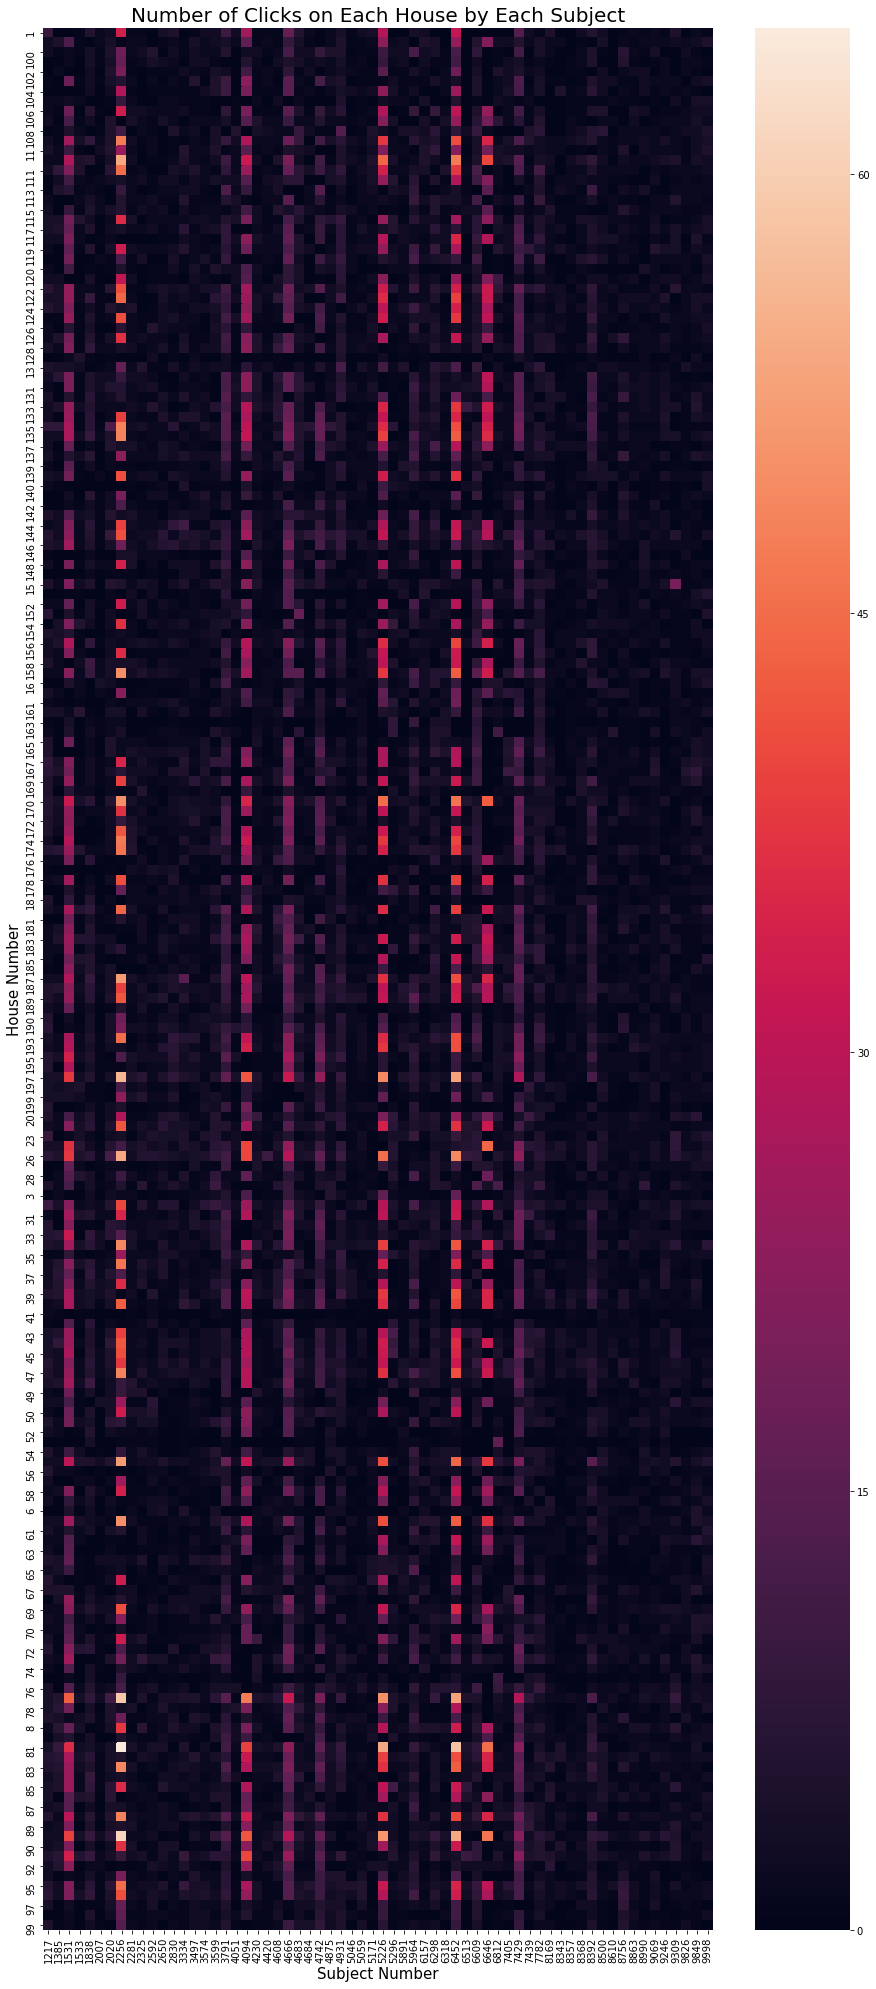

In [56]:
plt.figure(figsize=(15,35))
sns.heatmap(AllDf)
plt.title('Number of Clicks on Each House by Each Subject',fontsize=20)
plt.ylabel('House Number',fontsize=15)
plt.xlabel('Subject Number',fontsize=15)
#plt.show()
plt.savefig('Results/ClickHeatmap.png')

## Task Performance

#### Load Data into DataFrame

In [57]:
def mat_to_py(AlignmentPath,number):
    '''
    converts mat struct with task results into (numpy) array

    also adds extra column with information whether trial was correct or wrong
    
    conditions = ["Absolute - 3s ","Absolute - inf","Relative - 3s ","Relative - inf","Pointing 3s   ","Pointing - inf"]
    '''
    path = AlignmentPath+"/AlignmentVR_SubjNo_"+number+".mat"
    mat_contents = spio.loadmat(path)
    type_array = []
    for i,cond_1 in enumerate(["Absolute", "Relative","Pointing"]):
        for j,cond_2 in enumerate(["Trial_3s", "Trial_Inf"]):
            trials_array = []
            for line in range(len(mat_contents['Output'][0][0][cond_1][cond_2][0][0])):
                value_array = []
                for column in range(len(mat_contents['Output'][0][0][cond_1][cond_2][0][0][line][0])):
                    value = mat_contents['Output'][0][0][cond_1][cond_2][0][0][line][0][column][0][0]
                    value_array.append(value)
                # check if trial is correct(true or false
                value_array.append(value_array[-1] == value_array[-3])
                trials_array.append(value_array)

            type_array.append(trials_array)

    return np.array(type_array)

In [180]:
conditions = ["Absolute - 3s ","Absolute - inf","Relative - 3s ","Relative - inf","Pointing 3s   ","Pointing - inf"]
vp_nums = list(AllDf)
AllResults = np.zeros((6,len(vp_nums),36))#AllResults[condition][subjectNum][Trial]
AllHouses = np.zeros((6,len(vp_nums),36))
for i,e in enumerate(vp_nums):
    try:
        m = mat_to_py(taskPath,e)
        for c in range(6):       
            condperf = []
            house = []
            for t in range(36):
                condperf.append(int(m[c][t][-1]))
                #print(m[c][t][0])
                house.append(str(m[c][t][0]))
            AllResults[c][i] = condperf
            AllHouses[c][i] = house
    except:
        print(str(e)+" Not in folder")

### Create Performance Matrix and Save as .cvs File

In [59]:
performances = np.zeros((6,len(AllDf.columns)))#pd.DataFrame()
vpN = pd.DataFrame(vp_nums,columns=['vp_number'])
for cond in range(6):
    performances[cond] = np.mean(AllResults[cond],axis=1)
p = pd.DataFrame(np.transpose(performances)) 
p.columns = conditions
p = vpN.join(p).set_index('vp_number')
#p.columns = vp_nums
#p = p.rename(index={0: 'Relative - 3s',1:'Relative - inf',2:'Absolute - 3s',3:'Absolute - inf',4:'Pointing 3s',5:'Pointing - inf'})
p.to_csv('MapPerformances.csv')

In [60]:
p

,Absolute - 3s,Absolute - inf,Relative - 3s,Relative - inf,Pointing 3s,Pointing - inf
vp_number,,,,,,
1217,0.722222,0.583333,0.500000,0.555556,0.555556,0.555556
1385,0.500000,0.500000,0.388889,0.472222,0.444444,0.583333
1531,0.611111,0.416667,0.527778,0.416667,0.583333,0.611111
1533,0.500000,0.527778,0.472222,0.666667,0.472222,0.611111
1838,0.472222,0.555556,0.388889,0.472222,0.555556,0.555556
2007,0.555556,0.527778,0.555556,0.583333,0.500000,0.611111
2020,0.472222,0.555556,0.527778,0.472222,0.472222,0.500000
2256,0.527778,0.527778,0.416667,0.611111,0.444444,0.555556
2281,0.333333,0.500000,0.638889,0.638889,0.500000,0.500000


### Visualize Overall Statistics

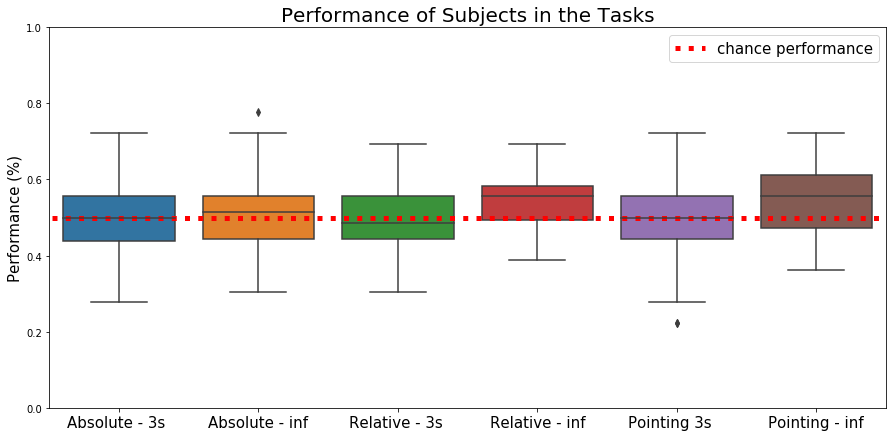

In [61]:
#group tasks
#color by time condition
fig,ax = plt.subplots(figsize=(15,7))
plt.plot([-5,10],[0.5,0.5],':',color='r', linewidth=5)
plt.legend(['chance performance'],fontsize=15)
sns.boxplot(data=[np.mean(AllResults[0],axis=1),np.mean(AllResults[1],axis=1),np.mean(AllResults[2],axis=1),np.mean(AllResults[3],axis=1),np.mean(AllResults[4],axis=1),np.mean(AllResults[5],axis=1)])
ax.set_xticklabels(conditions,fontsize=15)
ax.set_ylim((0,1))
plt.title('Performance of Subjects in the Tasks',fontsize=20)
plt.ylabel('Performance (%)',fontsize=15)
#plt.show()
plt.savefig('Results/TaskPerformances.png')

### Performance in Relation to Clicks

In [168]:
bins = [0,1,2,3,4,5,6]
binPerf = np.zeros(7)
binCount = np.zeros(7)
conds = [1,3,5]
for c in conds:#range(6):
    for i,s in enumerate(vp_nums):
        for t in range(36):
            house = AllHouses[c][i][t]
            #print(int(house))
            numviews = AllDf.loc[int(house)][s]
            if numviews<7:
                binPerf[numviews] = binPerf[numviews] + AllResults [c][i][t]
                binCount[numviews] = binCount[numviews] + 1
            else:
                binPerf[6] = binPerf[6] + AllResults [c][i][t]
                binCount[6] = binCount[6] + 1
perfclicks = pd.DataFrame({'bins':bins,'perf':binPerf/binCount,'numDPinBin':binCount})  
perfclicks

,bins,numDPinBin,perf
0,0,754.0,0.521220
1,1,1219.0,0.522559
2,2,1315.0,0.520913
3,3,1024.0,0.544922
4,4,703.0,0.527738
5,5,377.0,0.559682
6,6,1520.0,0.526974


In [98]:
perfclicks.to_csv('Results/ClickPerfInf.csv')

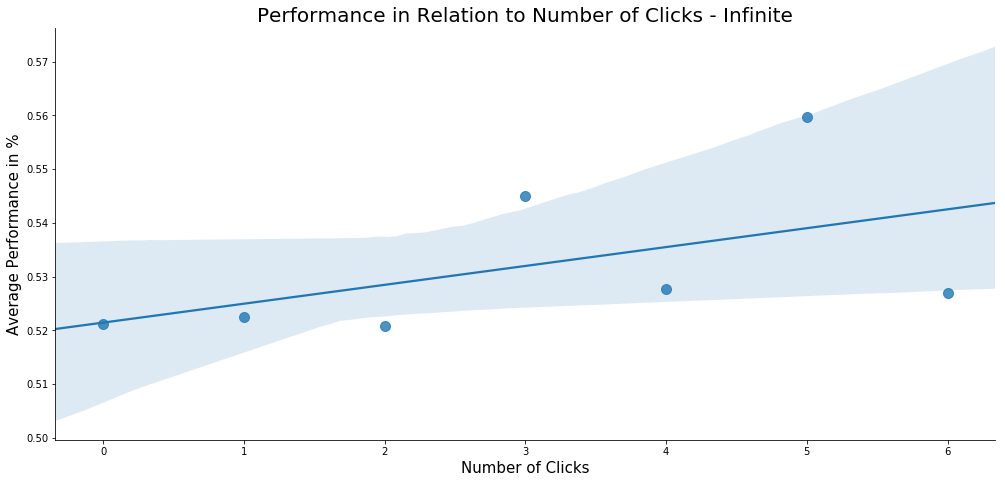

In [101]:
plot = sns.lmplot(x='bins',y='perf',data = perfclicks,size=7,aspect=2,scatter_kws={"s": 100})
plt.title('Performance in Relation to Number of Clicks - Infinite',fontsize=20)
plt.xlabel('Number of Clicks',fontsize=15)
plt.ylabel('Average Performance in %',fontsize=15)
plt.subplots_adjust(top=0.9)
#plt.show()
plt.savefig('Results/ClickPerfInf.png')

## Spatial Coverage of Seahaven

In [102]:
SeahavenMap = Image.open('map5.png')
coordinates = open("HouseList.txt","r")
coords = pd.DataFrame(columns={'House','x','y'})
for co in coordinates:
    x = float(co.split(':',1)[1].split(';',1)[0])
    y = float(co.split(';',1)[1])
    house = str(co.split(':',1)[0])
    coords = coords.append({'House':house,'x':x,'y':y},ignore_index=True)
coords = coords.set_index('House').sort_index()
overallClicks = np.sum(AllDf,axis=1)

In [132]:
SeahavenMap = Image.open('map5.png')
coordinates = open("HouseList.txt","r")
coords = pd.DataFrame(columns={'House','x','y'})
for co in coordinates:
    x = float(co.split(':',1)[1].split(';',1)[0])
    y = float(co.split(';',1)[1])
    house = str(co.split(':',1)[0])
    coords = coords.append({'House':house,'x':x,'y':y},ignore_index=True)
coords = coords.set_index('House').sort_index()
SJNumClicks = np.sum(AllDf>0,axis=1)

#### Look at Which Houses Were in the Map Task

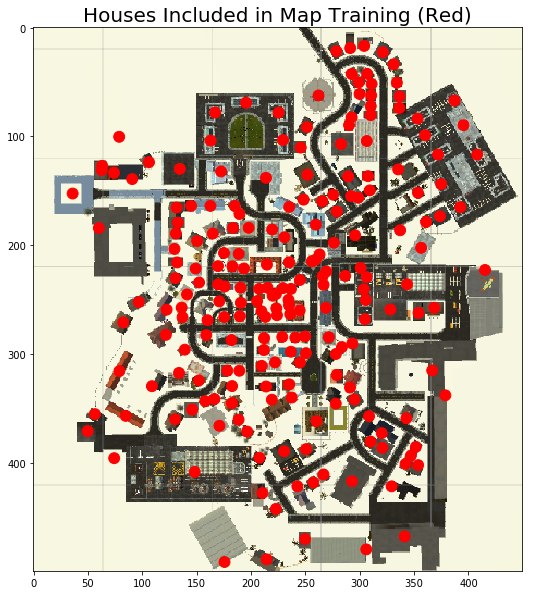

In [30]:
fig,ax = plt.subplots(figsize=(10,10))
SeahavenMap = SeahavenMap.resize((450,500))
plt.imshow(SeahavenMap)
for i in list(coords.index.values):
    try:
        #clicks = overallClicks.loc[i]
        ax.add_patch(Circle((coords['y'].loc[i],coords['x'].loc[i]), radius=5, color=(1,0,0)))
    except:
        ax.add_patch(Circle((coords['y'].loc[i],coords['x'].loc[i]), radius=5, color=(0,0,1)))
plt.title('Houses Included in Map Training (Red)',fontsize=20)
plt.show()
#plt.savefig('Results/MapNotIncluded.png')

#### Color Houses by Amount of Clicks (Green-Few, Red-Many, Black-Not Included)

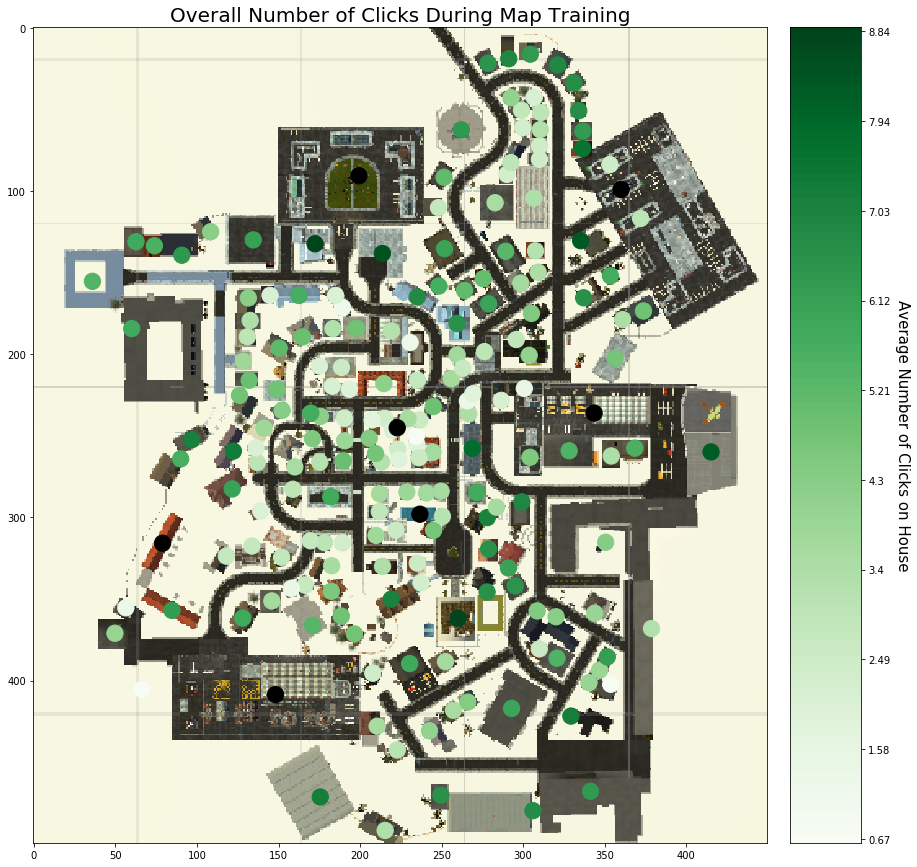

In [150]:
fig = plt.figure(figsize=(15,15))
SeahavenMap = SeahavenMap.resize((450,500))
ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
plt.imshow(SeahavenMap,aspect = 'equal')
cmap = plt.cm.get_cmap('Greens')
a=np.outer(np.arange(0,1,0.01),np.ones(3))
for i in list(coords.index.values):
    try:
        clicks = overallClicks.loc[int(i)]
        rgba = cmap((clicks-min(overallClicks))/(max(overallClicks)-min(overallClicks)))
        ax.add_patch(Circle((coords['y'].loc[i]-535,coords['x'].loc[i]-180), radius=5, color=(rgba)))
        #ax.add_patch(Circle((coords['y'].loc[i]-535,coords['x'].loc[i]-180), radius=5, color=((clicks-min(overallClicks))/(max(overallClicks)-min(overallClicks)),1-(clicks-min(overallClicks))/(max(overallClicks)-min(overallClicks)),0)))
    except:
        ax.add_patch(Circle((coords['y'].loc[i]-535,coords['x'].loc[i]-180), radius=5, color=(0,0,0)))
    
plt.title('Overall Number of Clicks During Map Training',fontsize=20)
ax2 = plt.subplot2grid((10, 10), (0, 9),rowspan=10)
plt.imshow(a,aspect='auto',cmap='Greens',origin="lower")
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks(np.linspace(0,99,10))
ax2.get_yaxis().set_ticklabels(np.around(np.linspace(min(overallClicks)/len(AllDf.columns),max(overallClicks)/len(AllDf.columns),10),2))
ax2.yaxis.tick_right()
ax2.set_ylabel("Average Number of Clicks on House",rotation=270, fontsize=15, labelpad=20)
ax2.yaxis.set_label_position("right")
#plt.show()
plt.savefig('Results/MapClicks.png')

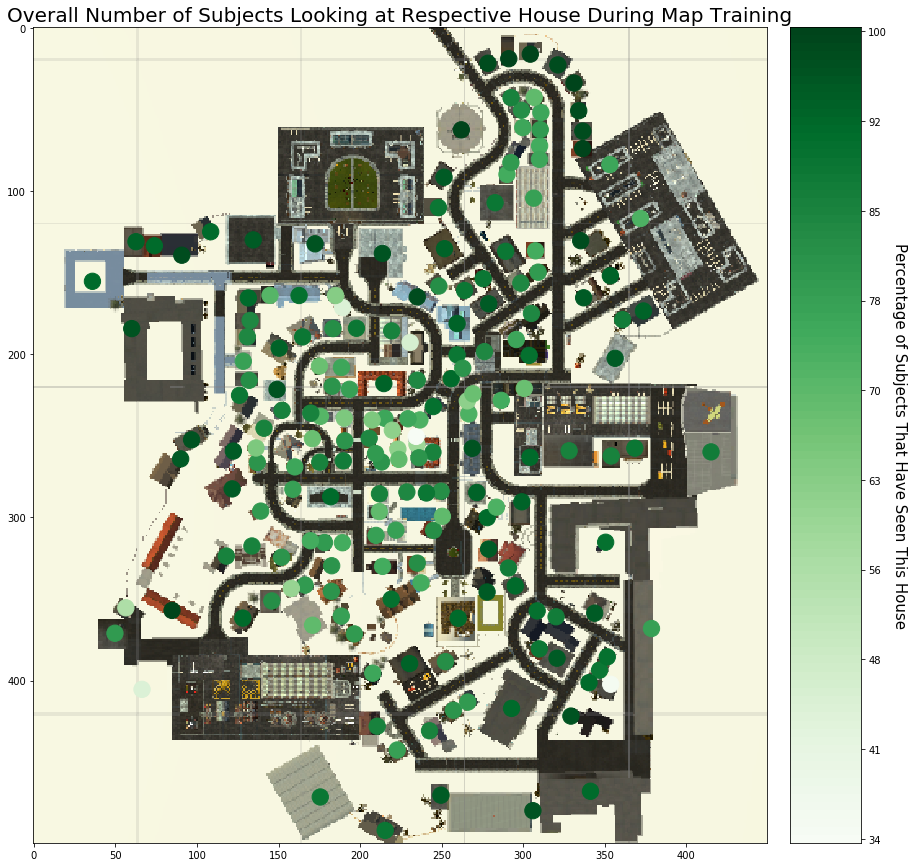

In [165]:
import math
fig = plt.figure(figsize=(15,15))
SeahavenMap = SeahavenMap.resize((450,500))
ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
plt.imshow(SeahavenMap,aspect = 'equal')
cmap = plt.cm.get_cmap('Greens')
a=np.outer(np.arange(0,1,0.01),np.ones(3))
for i in list(coords.index.values):
    try:
        clicks = SJNumClicks.loc[int(i)]
        rgba = cmap((clicks-min(SJNumClicks))/(max(SJNumClicks)-min(SJNumClicks)))
        ax.add_patch(Circle((coords['y'].loc[i]-535,coords['x'].loc[i]-180), radius=5, color=(rgba)))
        #ax.add_patch(Circle((coords['y'].loc[i]-535,coords['x'].loc[i]-180), radius=5, color=((clicks-min(overallClicks))/(max(overallClicks)-min(overallClicks)),1-(clicks-min(overallClicks))/(max(overallClicks)-min(overallClicks)),0)))
    except:
        continue
        #ax.add_patch(Circle((coords['y'].loc[i]-535,coords['x'].loc[i]-180), radius=5, color=(0,0,0)))
    
plt.title('Overall Number of Subjects Looking at Respective House During Map Training',fontsize=20)
ax2 = plt.subplot2grid((10, 10), (0, 9),rowspan=10)
plt.imshow(a,aspect='auto',cmap='Greens',origin="lower")
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks(np.linspace(0,99,10))
ax2.get_yaxis().set_ticklabels(np.linspace((min(SJNumClicks)/len(AllDf.columns))*100,(max(SJNumClicks)/len(AllDf.columns))*100,10,dtype=int))
ax2.yaxis.tick_right()
ax2.set_ylabel("Percentage of Subjects That Have Seen This House",rotation=270, fontsize=15, labelpad=20)
ax2.yaxis.set_label_position("right")
#plt.show()
plt.savefig('Results/MapSujClicks.png')

## Angular Differences

In [177]:
f2 = open("complete_list_houses.txt","r")
angles = {}
for line in f2:
    house = int(line.split('_',1)[0].split('n',1)[0])
    angle = int(line.split('_',1)[1].split('n',1)[0])
    angles[house] = angle
vp_nums = list(AllDf)
degree_30 = np.zeros((6,2))
degree_60 = np.zeros((6,2))
degree_90 = np.zeros((6,2))
degree_120 = np.zeros((6,2))
degree_150 = np.zeros((6,2))
degree_180 = np.zeros((6,2))
degrees = []
for i,e in enumerate(vp_nums):
    m = mat_to_py(taskPath,e)
    for cond in range(6):       
        for trial in range(36):
            degree = 0
            if cond < 2 or cond >3: # abs und poi
                degree = abs(int(m[cond][trial][-5])-int(m[cond][trial][-6])) # save angular diff in var
            else: # rel
                degree = abs(angles[m[cond][trial][-5]]-angles[m[cond][trial][-6]])
            degrees.append(degree)
            if degree <= 30 or degree >= 330:
                degree_30[cond][0] += 1 # increment counter for overall trial with 30 degree diff
                if m[cond][trial][-1]:
                    degree_30[cond][1] += 1 # increment counter for correct trial with 30 degree diff
            elif degree <= 60 or degree >= 300:
                degree_60[cond][0] += 1
                if m[cond][trial][-1]:
                    degree_60[cond][1] += 1
            elif degree <= 90 or degree >= 270:
                degree_90[cond][0] += 1
                if m[cond][trial][-1]:
                    degree_90[cond][1] += 1
            elif degree <= 120 or degree >= 240:
                degree_120[cond][0] += 1
                if m[cond][trial][-1]:
                    degree_120[cond][1] += 1
            elif degree <= 150 or degree >= 210:
                degree_150[cond][0] += 1
                if m[cond][trial][-1]:
                    degree_150[cond][1] += 1
            else:
                degree_180[cond][0] += 1
                if m[cond][trial][-1]:
                    degree_180[cond][1] += 1
allDegs = [degree_30,degree_60,degree_90,degree_120,degree_150,degree_180]

#### Quick Overview Over Distribution of Angular Differences in the Data

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


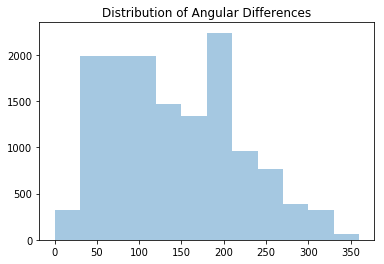

In [178]:
sns.distplot(degrees,norm_hist=False,kde=False,bins=[0,30,60,90,120,150,180,210,240,270,300,330,360])
plt.title('Distribution of Angular Differences')
plt.show()

#### Distribution of Degree Differences in the Tasks
just for checking that everything is right

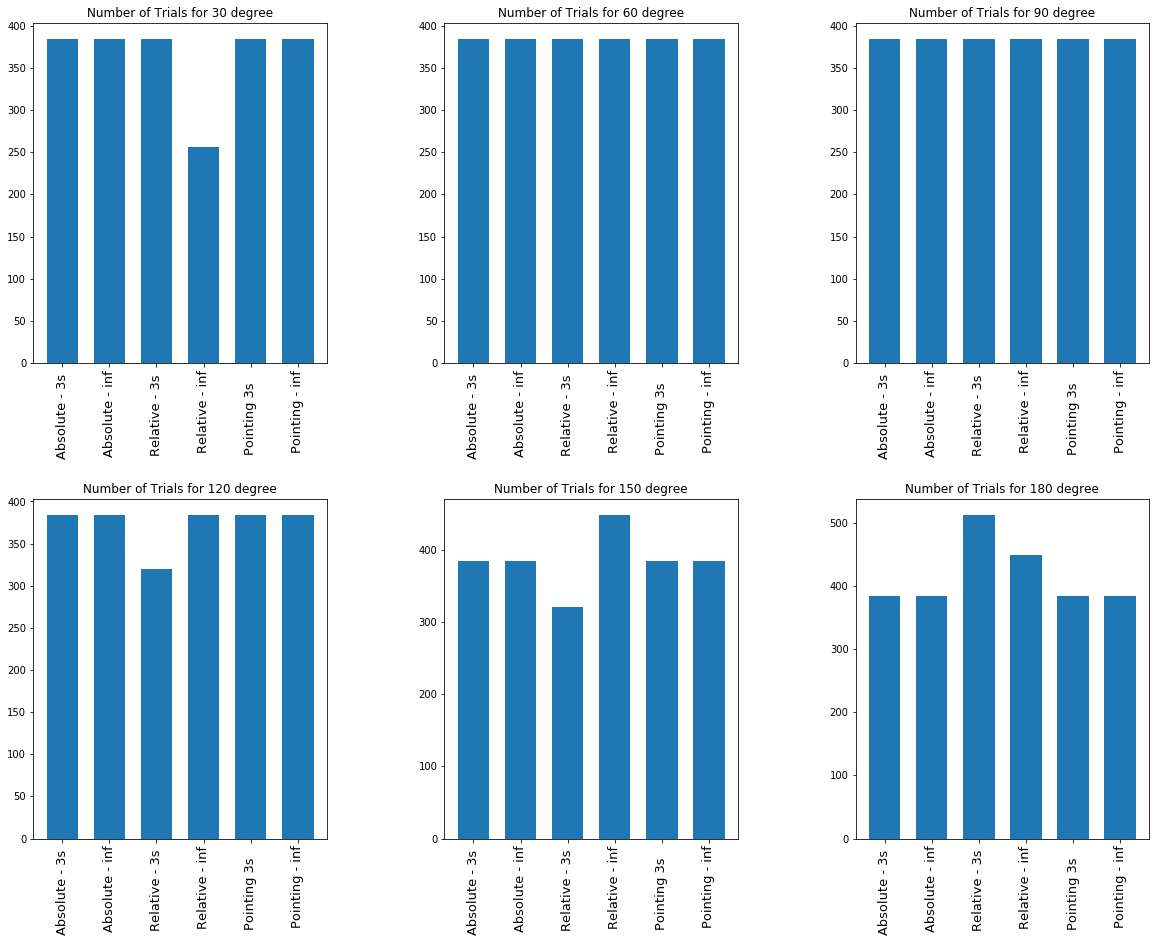

In [181]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
degs = [30,60,90,120,150,180]
for d in range(6):
    ax = plt.subplot(2,3,d+1)
    plt.bar(np.linspace(30,180,6),allDegs[d][:,0],width=20)
    plt.title('Number of Trials for '+str(degs[d])+' degree')
    plt.xticks([30,60,90,120,150,180],rotation=90,fontsize=13)
    ax.set_xticklabels(conditions)
plt.show()

#### Performance Dependent on Angular Difference for Each Task

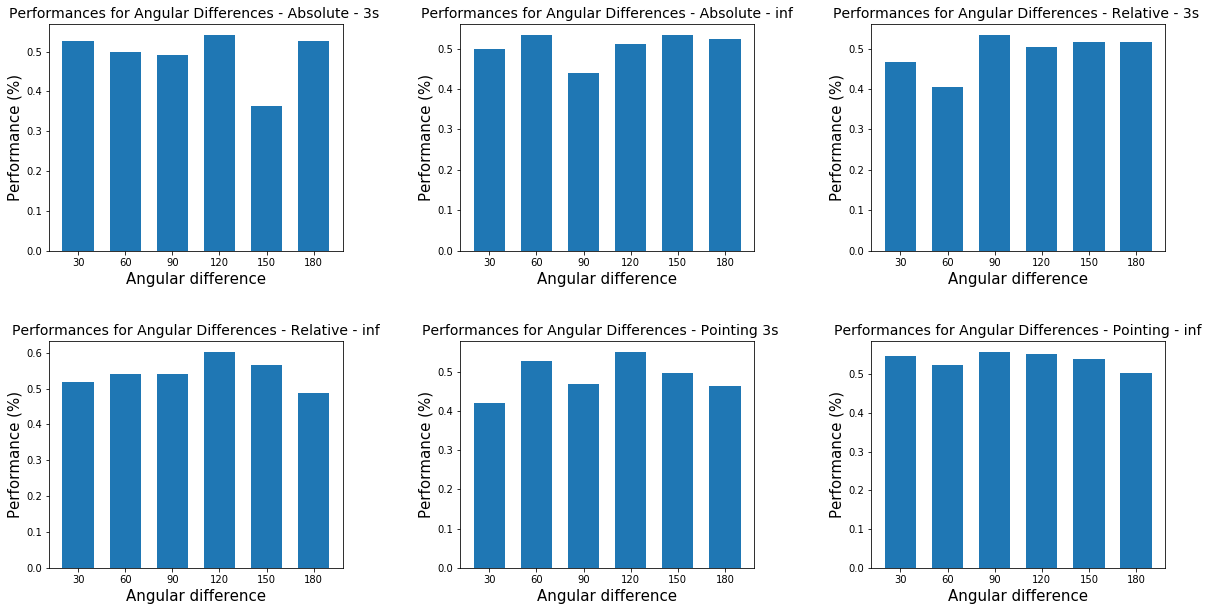

In [183]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for c in range(6):
    plt.subplot(2,3,c+1)
    a = np.array([x[c][0] for x in allDegs])
    p = np.array([x[c][1] for x in allDegs])
    plt.bar(np.linspace(30,180,6),p/a,width=20)
    plt.title('Performances for Angular Differences - '+conditions[c],fontsize=14)
    plt.xlabel('Angular difference',fontsize=15)
    plt.ylabel('Performance (%)',fontsize=15)
    plt.xticks([30,60,90,120,150,180])
#plt.show()
plt.savefig('Results/AngularDifPerf.png')

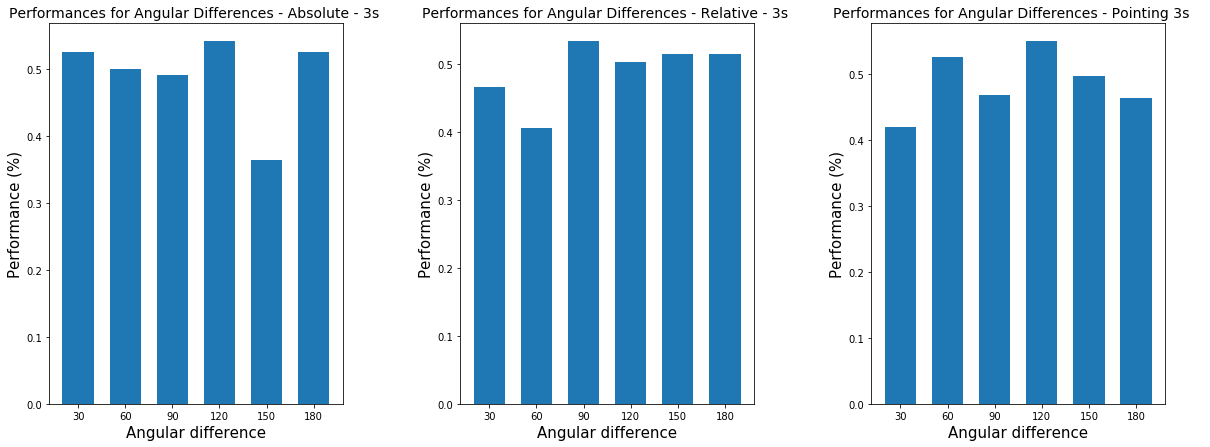

In [220]:
fig = plt.figure(figsize=(20,7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
CondPerfs = np.zeros((1,6))
#conds = [1,3,5]
conds = [0,2,4]
for n,c in enumerate(conds):
    plt.subplot(1,3,n+1)
    a = np.array([x[c][0] for x in allDegs])
    p = np.array([x[c][1] for x in allDegs])
    CondPerfs = CondPerfs+p/a
    plt.bar(np.linspace(30,180,6),p/a,width=20)
    plt.title('Performances for Angular Differences - '+conditions[c],fontsize=14)
    plt.xlabel('Angular difference',fontsize=15)
    plt.ylabel('Performance (%)',fontsize=15)
    plt.xticks([30,60,90,120,150,180])
plt.show()
#plt.savefig('Results/AngularDifPerf.png')

In [221]:
pd.DataFrame((CondPerfs/len(conds))[0]).to_csv('AngDiffPerf_3s.csv')

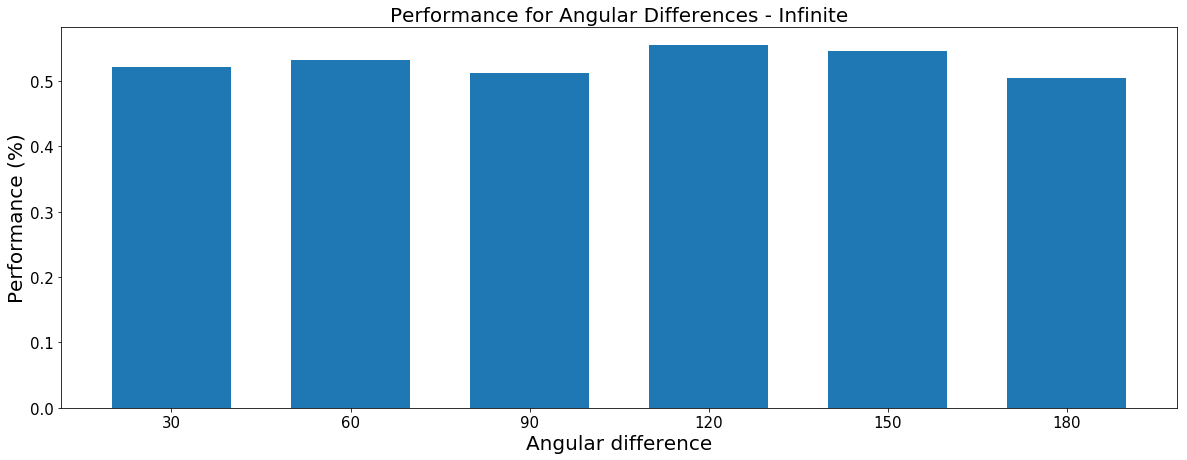

In [216]:
fig,ax = plt.subplots(figsize=(20,7))
plt.bar(np.linspace(30,180,6),(CondPerfs/len(conds))[0],width=20)
plt.title('Performance for Angular Differences - Infinite',fontsize=20)
plt.xlabel('Angular difference',fontsize=20)
plt.ylabel('Performance (%)',fontsize=20)
plt.xticks([30,60,90,120,150,180])
ax.tick_params(labelsize=15)
#plt.show()
plt.savefig('Results/AngularDifPerfInf.png')

#### Performance Dependent on Angular Difference for All Tasks

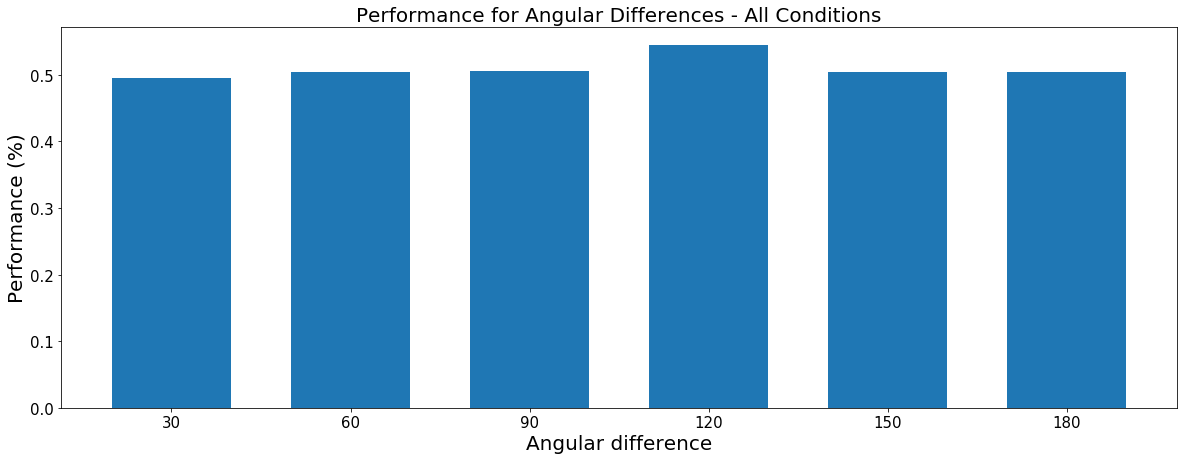

In [189]:
fig,ax = plt.subplots(figsize=(20,7))
plt.bar(np.linspace(30,180,6),np.sum(allDegs,axis=1)[:,1]/np.sum(allDegs,axis=1)[:,0],width=20)
plt.title('Performance for Angular Differences - All Conditions',fontsize=20)
plt.xlabel('Angular difference',fontsize=20)
plt.ylabel('Performance (%)',fontsize=20)
plt.xticks([30,60,90,120,150,180])
ax.tick_params(labelsize=15)
plt.show()
#plt.savefig('Results/AngularDifPerfAll.png')

## Performance in Relation to Distance Between Houses

In [222]:
coordinates = open("HouseList.txt","r")
coords = pd.DataFrame(columns={'House','x','y'})
for co in coordinates:
    x = float(co.split(':',1)[1].split(';',1)[0])
    y = float(co.split(';',1)[1])
    house = str(int(co.split(':',1)[0]))
    coords = coords.append({'House':house,'x':x,'y':y},ignore_index=True)
coords = coords.set_index('House').sort_index()

In [234]:
vp_nums = list(AllDf)
DistPerfs = np.zeros((4,len(vp_nums)*36,2))#DistPerfs[Condition][Trials][Performance,Distance]
#relative task: distance = prime - target (distractor ignored) -> XX check in matlab if target is always named first
#absolute task: ignored bc there is no distance
#pointing task: distance = prime - target
for i,v in enumerate(vp_nums):
    m = mat_to_py(taskPath,e)
    for cond in range(4):
        for trial in range(36):
            if cond <2:#relative
                h1 = (coords['x'].loc[str(m[cond+2][trial][0])],coords['y'].loc[str(m[cond+2][trial][0])])
                if m[cond][trial][3]=='U':
                    h2 = (coords['x'].loc[str(m[cond+2][trial][1])],coords['y'].loc[str(m[cond+2][trial][1])])
                else:
                    h2 = (coords['x'].loc[str(m[cond+2][trial][2])],coords['y'].loc[str(m[cond+2][trial][2])])
                dist = distance.euclidean(h1, h2)
            if cond >1:#pointing
                h1 = (coords['x'].loc[str(m[cond+2][trial][0])],coords['y'].loc[str(m[cond+2][trial][0])])
                h2 = (coords['x'].loc[str(m[cond+2][trial][1])],coords['y'].loc[str(m[cond+2][trial][1])])
                dist = distance.euclidean(h1, h2)
            DistPerfs[cond][i*36+trial][0] = int(m[cond][trial][-1])
            DistPerfs[cond][i*36+trial][1] = dist

#### Plot Distribution of Distances Between Houses for Correct and Incorrect Distances
-> The houses in the wrongly answered questions have a higher distance on average

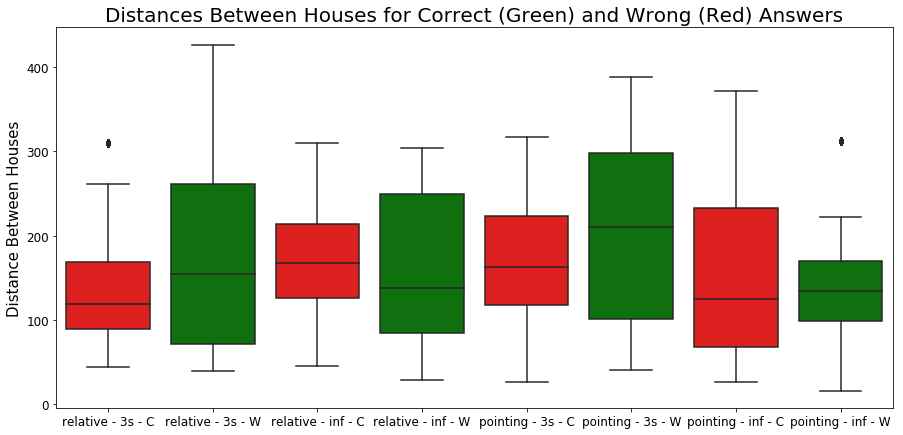

In [246]:
fig,ax = plt.subplots(figsize=(15,7))
my_pal = {'g','r'}
ax = sns.boxplot(data=[DistPerfs[0][DistPerfs[0][:,0]==1][:,1],DistPerfs[0][DistPerfs[0][:,0]==0][:,1],
                       DistPerfs[1][DistPerfs[1][:,0]==1][:,1],DistPerfs[1][DistPerfs[1][:,0]==0][:,1],
                      DistPerfs[2][DistPerfs[2][:,0]==1][:,1],DistPerfs[2][DistPerfs[2][:,0]==0][:,1],
                       DistPerfs[3][DistPerfs[3][:,0]==1][:,1],DistPerfs[3][DistPerfs[3][:,0]==0][:,1]],palette=my_pal)
ax.set_xticklabels(["relative - 3s - C", "relative - 3s - W","relative - inf - C","relative - inf - W","pointing - 3s - C","pointing - 3s - W","pointing - inf - C","pointing - inf - W"])
ax.tick_params(labelsize=12)
plt.title('Distances Between Houses for Correct (Green) and Wrong (Red) Answers',fontsize=20)
plt.ylabel('Distance Between Houses',fontsize=15)
#plt.show()
plt.savefig('Results/DistPerfBox.png')

## Plot Distances as Regression Plot
#### Visualize the Binning for Each Task
Binning is done looking at the four percentiles in the distances -> equal amount of data in each of the four bins

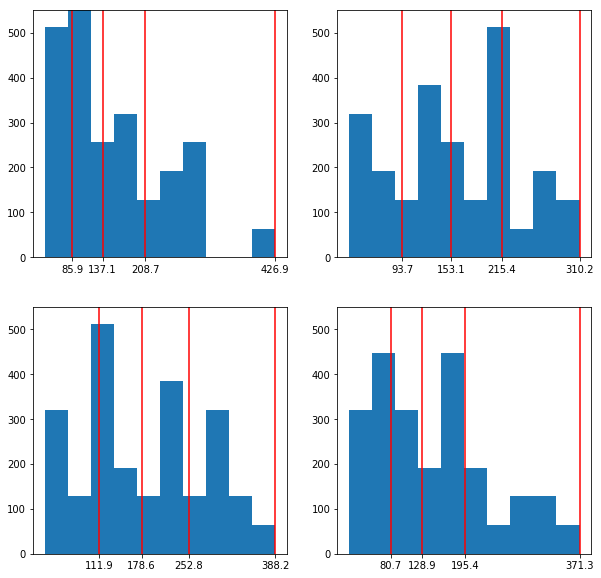

In [247]:
plt.figure(figsize=(10,10))
performances = np.zeros((4,4,2))#perc[cond][percentile][perf,count]

for cond in range(4):
    lowerBound = 0
    plt.subplot(2,2,cond+1)
    plt.hist(DistPerfs[cond][:,1])
    bounds = np.zeros((4))
    for perc in range(4):
        upperBound = np.percentile(DistPerfs[cond][:,1], (perc+1)*25)
        plt.vlines(upperBound,0,550,color='r')
        plt.ylim(0,550)
        bounds[perc]=upperBound
        for perf in DistPerfs[cond]:
            if perf[1]>=lowerBound and perf[1]<=upperBound:
                performances[cond][perc][0] = performances[cond][perc][0] + perf[0]
                performances[cond][perc][1] = performances[cond][perc][1] + 1
        lowerBound = upperBound
    plt.xticks(bounds)
        #print(str((perc+1)*25)+'th percentile: '+str(upperBound)[:5])    

#### Plot Performance Dependent on the Distance Bins

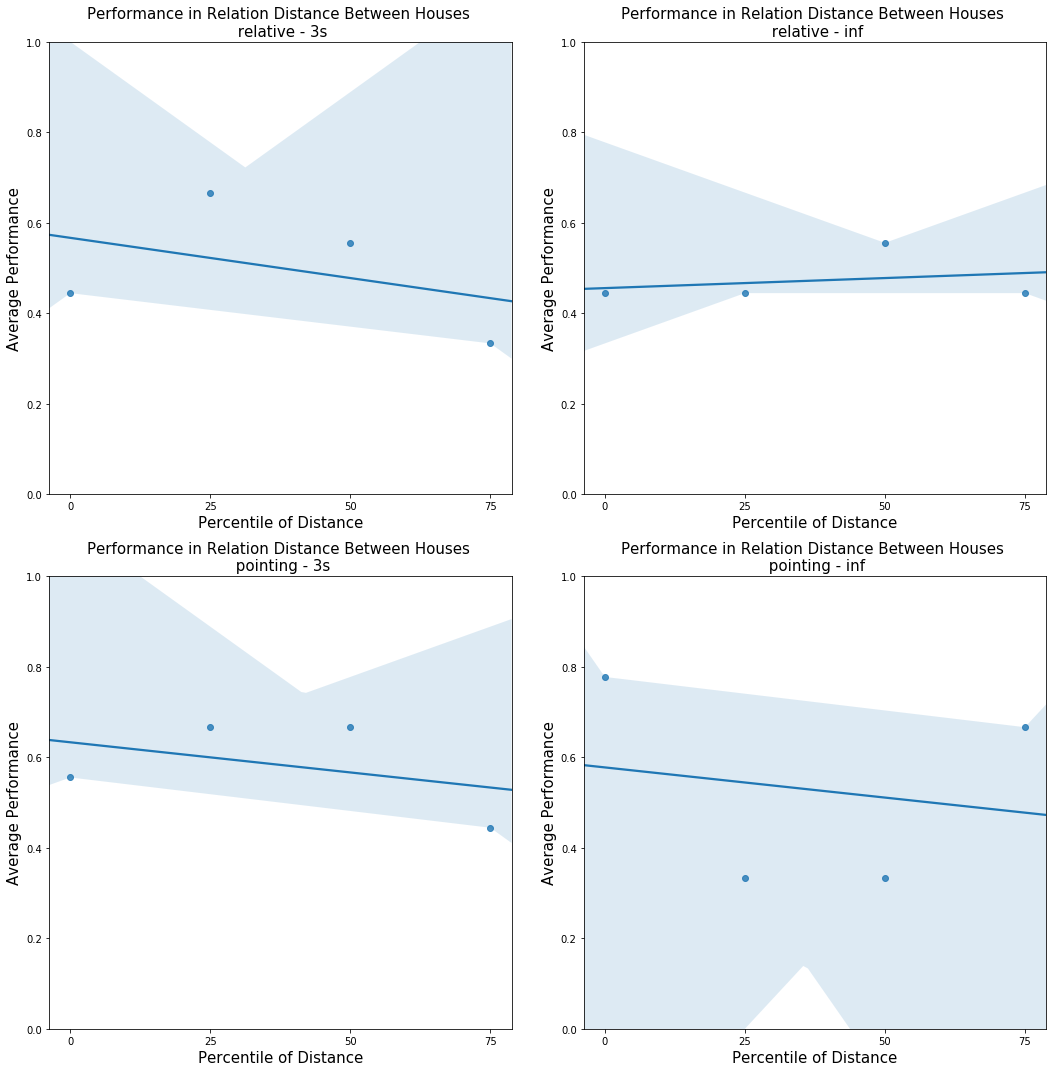

In [248]:
percentiles = [0,25,50,75]
tasks = ['relative - 3s','relative - inf','pointing - 3s','pointing - inf']
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for cond in range(4):
    plt.subplot(2,2,cond+1)
    perfDf = pd.DataFrame({'perc':percentiles,'perf':performances[cond,:,0]/performances[cond,:,1],'numDPinBin':performances[cond,:,1]})  
    plot = sns.regplot(x='perc',y='perf',data = perfDf)#,size=7,aspect=2,scatter_kws={"s": 100})
    plt.title('Performance in Relation Distance Between Houses \n '+str(tasks[cond]),fontsize=15)
    plt.xlabel('Percentile of Distance',fontsize=15)
    plt.ylabel('Average Performance',fontsize=15)
    plt.ylim(0,1)
    plt.xticks(percentiles)
plt.tight_layout()
#plt.show()
plt.savefig('Results/DistPerfReg.png')

## Repeated Measurements

In [38]:
allFiles = os.listdir(mapPath)
conditions = ["Absolute - 3s ","Absolute - inf","Relative - 3s ","Relative - inf","Pointing 3s   ","Pointing - inf"]
g = open("./complete_list_houses.txt","r")
allHouses = []
for i in g:
    allHouses.append(str(int(i.split('_',1)[0])))
performances = pd.DataFrame(columns=['Subject','Measurement','Condition','Performance'])
for e in allFiles:
    if e.endswith(".ods"):
        usable,code = checkUsability(int(e.split('.',1)[0]),Rep=True)    
        if usable:
            m = mat_to_py(taskPath,(e.split('.',1)[0]))
            for c in range(6):       
                for t in range(36):
                    performances = performances.append({'Subject': ord(str(code)[1])-97,'Measurement':int(str(code)[0])-1,
                                                   'Condition':c,'Performance':int(m[c][t][-1])}, ignore_index=True)           

#### Plot Performances Averaged over 11 Repeated Measure Subjects

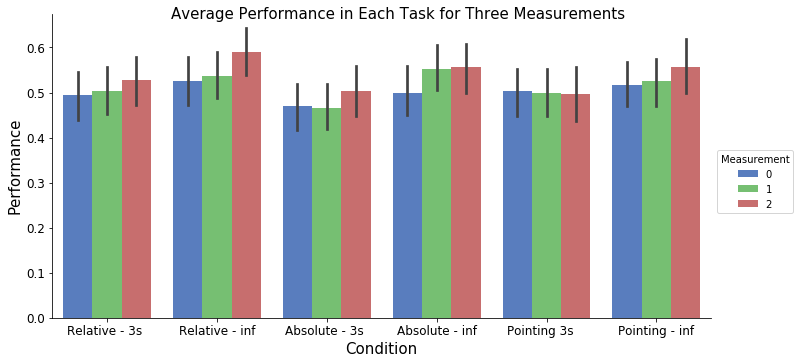

In [39]:
performances['Performance'] = performances['Performance'].astype(float)
ax = sns.factorplot(x="Condition", y="Performance", hue="Measurement",data=performances,
                   size=5, kind="bar", palette="muted",aspect=2)
ax.set_xticklabels(conditions,fontsize=12)
ax.set_yticklabels(fontsize=12)
ax.set_xlabels('Condition',fontsize=15)
ax.set_ylabels('Performance',fontsize=15)
ax.fig.suptitle('Average Performance in Each Task for Three Measurements',fontsize=15)
#plt.show()
plt.savefig('Results/RepMeasPerf.png')